# Calculate Gas Fractions Using our Lookup Table for Stellar Mass Densities

Isaac Cheng - December 2021

Based on the [`gas_fraction.ipynb`](../galaxies/gas_fraction/gas_fraction.ipynb) notebook.

Note that the data should all be at VERTICO's 9" beam with 2" pixel resolution!


In [1]:
GAS_FRAC_PATH = "/arc/home/IsaacCheng/coop_f2021/compiled_results/gas_fraction_profiles/"  # change this path
%cd "$GAS_FRAC_PATH"

from multiprocessing import Pool
from itertools import repeat
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from radio_beam import Beam
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/compiled_results/gas_fraction_profiles


Following are arrays containing information related to the NGVS-VERTICO galaxies.


In [2]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degree. If inclination >= I_THRESHOLD, means high-i galaxy

GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles

The following function calculates the gas fraction radial profile of a galaxy using
stellar mass density data from a pickle file (see the [stellar mass
pipeline](../stellar_mass_pipeline/)).

N.B. You will need to change the import paths!


In [3]:
def get_gas_frac_rp(
    galaxy,  # galaxy name. string (e.g., "NGC4380")
    i,  # inclination. float or int
    pa,  # position angle. float or int
    n_annuli=None,  # number of annuli to use
    avg_uncertainty=False,  # if True, the radial profile calculates the average uncertainty instead of the average value. Note that this is different from the uncertainty in the mean!
    include_bad=None,  # overrides default include_bad
    snr_cutoff=None,  # fit annuli until it drops <= this SNR value
    avg_function="mean",  # "mean" or "median"
    max_snr_annuli=40,   # maximum number of annuli to use if using snr_cutoff
    min_width=None,  # the minimum width of the annuli
    bootstrap_errs=True,  # if True, estimate error on the mean using bootstrapping
    bootstrap_seed=1234,  # seed for bootstrapping
):
    """
    Calculates the gas fraction radial profile for a given galaxy. Also saves the annulus
    width and centre of the galaxy (useful for vorbin radial profiles).
    """
    #
    # Load stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"  # ! CHANGE ME
    galaxy_infile = (galpath + f"{galaxy}_regBin_extinctionCorr_9as_ugiz_Sigma-star_noNorm_i_corr.pkl")  # ! CHANGE ME
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        file = None  # free memory
    #
    # Load molecular gas density data
    #
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    #
    # Get radial profile parameters
    #
    centre = gal_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)  # VERTICO image centre = galaxy centre
    if i >= I_THRESHOLD:
        if include_bad is None:
            include_bad = False
        high_i_height = HIGH_I_HEIGHTS_ARCSEC[galaxy == HIGH_I_GALAXIES] * u.arcsec
    else:
        if include_bad is None:
            include_bad = True  # only include NaNs if low-i galaxy
        high_i_height = None
    if n_annuli is None and snr_cutoff is None:
        if galaxy == "NGC4698" or galaxy == "NGC4772":
            snr_cutoff = None
            n_annuli = 5
        else:
            snr_cutoff = 0  # fit until no gas detected
            n_annuli = None
    #
    # Get annulus width in degree (just to store)
    #
    beam = Beam.from_fits_header(gal_header)
    annulus_width_arcsec = np.max(
        [beam.major.to(u.arcsec).value, beam.minor.to(u.arcsec).value]
    )
    #
    # Mask background
    #
    Ico_mask = (~np.isfinite(Ico_unc)) | (Ico_unc <= 0)
    Ico_data[Ico_mask] = np.nan
    Ico_unc[Ico_mask] = np.nan
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = ALPHA_CO / R_21 * Ico_data
    gas_density_unc_i_uncorr = ALPHA_CO / R_21 * Ico_unc
    #
    # Correct for inclination
    #
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr, i, i_threshold=I_THRESHOLD, i_replacement=I_THRESHOLD
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr, i, i_threshold=I_THRESHOLD, i_replacement=I_THRESHOLD
    )
    #
    # Convert to gas fraction
    #
    gas_frac, gas_frac_unc = fu.calc_gas_fraction(
        gas_density, M_density, gas_density_unc, M_density_err
    )
    #
    # Make radial profile
    #
    if avg_uncertainty:
        galaxy_rp = RadialProfile(gas_frac_unc, centre, i, pa, noise=None)
    else:
        galaxy_rp = RadialProfile(gas_frac, centre, i, pa, noise=gas_frac_unc)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        snr_cutoff=snr_cutoff,
        max_snr_annuli=max_snr_annuli,
        min_width=min_width,
        wcs=gal_wcs,
        header=gal_header,
        include_bad=include_bad,
        method="exact",
        func=avg_function,
        is_radio=True,
        high_i_height=high_i_height,
        bootstrap_errs=bootstrap_errs,
        bootstrap_seed=bootstrap_seed,
    )
    return galaxy_rp, centre, annulus_width_arcsec


## Get gas fraction radial profiles for all NGVS-VERTICO galaxies and save in 1 pickle file


First, load the VERTICO gas density radial profiles so that the number of annuli in the
gas density and gas fraction radial profiles match.

Alternatively, you can just fit annuli with an `snr_cutoff=0` (which is what I did for the
gas density radial profiles). In practice, this means it will keep adding annuli until it
reaches an annulus that contains all NaNs or is completely out of the image boundary.


In [4]:
# 
# Load VERTICO gas density radial profiles (to get n_annuli)
# 
with open("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pkl", "rb") as f:
    file = dill.load(f)
    vertico_gals = file["galaxies"]
    vertico_rps = file["radial_profiles"]
    file = None  # free memory
n_annulis = []
for g, rp in zip(vertico_gals, vertico_rps):
    if g not in GALAXIES:
        continue
    n_annulis.append(len(rp.annuli))
print(len(n_annulis))
print(n_annulis)  # here, n_annulis correspond to the alphabetized GALAXIES (make sure all lists/arrays correspond element-wise!)
print(GALAXIES)

36
[3, 19, 21, 9, 16, 3, 7, 6, 18, 15, 9, 5, 5, 5, 10, 8, 13, 3, 4, 4, 7, 7, 7, 4, 12, 11, 6, 5, 8, 11, 4, 7, 6, 8, 8, 5]
['IC3392' 'NGC4192' 'NGC4216' 'NGC4222' 'NGC4254' 'NGC4294' 'NGC4298'
 'NGC4299' 'NGC4302' 'NGC4321' 'NGC4330' 'NGC4351' 'NGC4380' 'NGC4383'
 'NGC4388' 'NGC4396' 'NGC4402' 'NGC4405' 'NGC4419' 'NGC4424' 'NGC4450'
 'NGC4501' 'NGC4522' 'NGC4532' 'NGC4535' 'NGC4548' 'NGC4567' 'NGC4568'
 'NGC4569' 'NGC4579' 'NGC4580' 'NGC4607' 'NGC4651' 'NGC4654' 'NGC4689'
 'NGC4694']


Use multiprocessing to get radial profiles in parallel. This is super fast.


In [5]:
# 
# Set the following 2 parameters
# 
calc_avg_uncertainty = True  # if True, calculate average uncertainty in annulus instead
include_masked_regions = False  # if True, include masked regions as zeros
# 
if calc_avg_uncertainty:
    unc_str = "_unc"
else:
    unc_str = ""
if include_masked_regions:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
# 
with Pool(processes=None) as p:
    radial_profiles, centers, annulus_widths_arcsec = zip(
        *p.starmap(
            get_gas_frac_rp,
            zip(
                GALAXIES,
                INCLINATIONS,
                POSITION_ANGLES,
                n_annulis,
                repeat(calc_avg_uncertainty),
                repeat(include_masked_regions),
            ),
        )
    )
radial_profiles = list(radial_profiles)
centers = list(centers)
annulus_widths_arcsec = list(annulus_widths_arcsec)
print("Done")


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
WARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixe

Info: using provided WCS instead of converting header to WCS



WARNING
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58839.379235 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]



Info: using provided WCS instead of converting header to WCS

Getting minimum width from radio beam size

WARNINGWARNINGWARNINGWARNING

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58771.720579 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57613.735997 from DATE-OBS'. [astropy.wcs.wcs]WARNING

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]
WARNING

Getting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCS

Min width/beam size (pixels):


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58125.369839 from DATE-OBS'. [astropy.wcs.wcs]

4.50000000014364

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]



Info: using provided WCS instead of converting header to WCS


WARNING

Getting minimum width from radio beam size

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]


Min width/beam size (pixels):
 

WARNING


4.5000000002462395

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58822.371327 from DATE-OBS'. [astropy.wcs.wcs]WARNING


Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58857.486979 from DATE-OBS'. [astropy.wcs.wcs]

WARNING


Getting minimum width from radio beam size

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNINGWARNING

Min width/beam size (pixels):


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

4.5000000001472396

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58800.586857 from DATE-OBS'. [astropy.wcs.wcs]


Getting minimum width from radio beam sizeInfo: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli

Min width/beam size (pixels):

WARNINGWARNINGWARNINGWARNING

Height (pixels):

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58837.406607 from DATE-OBS'. [astropy.wcs.wcs]

  Info: using provided WCS instead of converting header to WCS


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58827.396029 from DATE-OBS'. [astropy.wcs.wcs]
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58830.570338 from DATE-OBS'. [astropy.wcs.wcs]


4.5000000001598432.4999999999974Info: using provided WCS instead of converting header to WCS
Info: using provided WCS instead of converting header to WCS


WARNING

WARNING

Min width/beam size (pixels):

WARNINGWARNINGWARNING
WARNING

Getting minimum width from radio beam size

WARNING

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58807.603859 from DATE-OBS'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58811.578396 from DATE-OBS'. [astropy.wcs.wcs]



4.500000000210241

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58910.235509 from DATE-OBS'. [astropy.wcs.wcs]
WARNINGWARNING
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58906.231702 from DATE-OBS'. [astropy.wcs.wcs]

WARNING


Info: using provided WCS instead of converting header to WCS

WARNING
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58855.371869 from DATE-OBS'. [astropy.wcs.wcs]WARNING

Getting minimum width from radio beam size

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58858.416048 from DATE-OBS'. [astropy.wcs.wcs]

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58835.533518 from DATE-OBS'. [astropy.wcs.wcs]

Getting minimum width from radio beam size

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58855.352029 from DATE-OBS'. [astropy.wcs.wcs]

WARNING
WARNING


Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size

WARNING


Getting minimum width from radio beam size

Min width/beam size (pixels):

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]


 Min width/beam size (pixels):


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57729.380956 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58197.199664 from DATE-OBS'. [astropy.wcs.wcs]
: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

 4.50000000022464

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58184.283297 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

Getting minimum width from radio beam size


WARNING


4.50000000009684

Min width/beam size (pixels):

WARNING

Info: using provided WCS instead of converting header to WCS


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Info: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCS


Info: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCS

Min width/beam size (pixels):Info: using provided WCS instead of converting header to WCS
Min width/beam size (pixels):Min width/beam size (pixels):


Min width/beam size (pixels): Getting minimum width from radio beam size

WARNING

Info: using provided WCS instead of converting header to WCS




: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]


Getting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCS

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

Getting minimum width from radio beam size
 

Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam sizeGetting minimum width from radio beam size

4.50000000044063954.50000000019764

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58203.170749 from DATE-OBS'. [astropy.wcs.wcs]



Getting minimum width from radio beam sizeGetting minimum width from radio beam size
4.49773120432584



: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]



Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size
 Getting minimum width from radio beam size

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING


Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size




Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Min width/beam size (pixels):

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]


Min width/beam size (pixels):
Info: using provided WCS instead of converting header to WCS

Getting minimum width from radio beam size
Info: using provided WCS instead of converting header to WCS

4.50000000014904
Min width/beam size (pixels):

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)


WARNING

Min width/beam size (pixels):
Min width/beam size (pixels):Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuliInfo: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCS


Min width/beam size (pixels):Min width/beam size (pixels):Getting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size

4.50000000014004Getting minimum width from radio beam size 

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

 
 4.50000000012024Min width/beam size (pixels):  

Min width/beam size (pixels):Min width/beam size (pixels):

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:555: RuntimeWarning: invalid value encountered in true_divide
  bootstraps = bootstraps / np.nansum(_area)


4.50000000015804
4.500000000163444.50000000011664

 Getting minimum width from radio beam size
 
Height (pixels):Getting minimum width from radio beam sizeMin width/beam size (pixels):4.500000000219244.50000000012564 Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuliInfo: using provided WCS instead of converting header to WCS 


WARNING

Getting minimum width from radio beam size

4.5000000000752394.50000000019044 
 
Getting minimum width from radio beam size
Height (pixels):4.500000000203044.50000000016344

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Min width/beam size (pixels):


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58837.456786 from DATE-OBS'. [astropy.wcs.wcs]


39.9999999999968
4.50000000012204Min width/beam size (pixels):Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
 

 Min width/beam size (pixels):Getting minimum width from radio beam size


Info: using provided WCS instead of converting header to WCS Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli


Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli4.5000000002840395 Min width/beam size (pixels):




34.9999999999972 4.50000000020844Getting minimum width from radio beam sizeMin width/beam size (pixels):4.500000000179639


WARNING


 Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuliMin width/beam size (pixels):Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]



 
4.50000000016704


4.50000000017604

Height (pixels):Height (pixels):Height (pixels):Info: using provided WCS instead of converting header to WCS Min width/beam size (pixels):Min width/beam size (pixels):  Height (pixels):
19.999999999998421.49999999999828 18.999999999998483Min width/beam size (pixels): 4.500000000188639
Getting minimum width from radio beam size
Height (pixels):
27.4999999999978
  

Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
 5.092956068889193
12.499999999999002

4.50000000027684Height (pixels):Min width/beam size (pixels):Height (pixels):  
4.5000000001616405 29.9999999999976024.50000000021924


22.499999999998202


Info: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCS

Getting minimum width from radio beam sizeGetting minimum width from radio beam size



Min width/beam size (pixels):Min width/beam size (pixels):  Info: using provided WCS instead of converting header to WCS4.500000000233644.50000000013464


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000018684
Done


Save the results for all NGVS-VERTICO galaxies into 1 pickle file.


In [6]:
gas_fraction_outfile = GAS_FRAC_PATH + f"gas_fraction{unc_str}_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}.pkl"
with open(gas_fraction_outfile, "wb") as f:
    dill.dump(
        {
            "galaxies": GALAXIES,
            "inclinations": INCLINATIONS,
            "position_angles": POSITION_ANGLES,
            "radial_profiles": radial_profiles,
            "centers": centers,
            "annulus_widths_arcsec": annulus_widths_arcsec,
            "n_annulis": n_annulis,
        },
        f
    )
print("Pickled", gas_fraction_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/compiled_results/gas_fraction_profiles/gas_fraction_unc_i_corr_NGVS-VERTICO_noNorm_noIncludeBad.pkl


## Make 1 gas fraction radial profile per galaxy


Plot radial profiles of gas fraction.


In [2]:
# 
# Load gas fraction values
# 
PLOT_INCLUDE_BAD = False  # determines pickle file to use
# 
if PLOT_INCLUDE_BAD:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
#
gas_fraction_outfile = GAS_FRAC_PATH + f"gas_fraction_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}.pkl"
with open(gas_fraction_outfile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
galaxies_wcs = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    tmp_gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    galaxies_wcs.append(tmp_gal_wcs)
    px_to_kpc = fu.calc_pc_per_px(tmp_gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

I_THRESHOLD = 80  # degree

In [3]:
# 
# Plot radial profile of gas fraction values
#
for galname, gal_centre, inclination, gal_wcs, gal_rp, gal_radius_kpc in zip(galaxies, centers, inclinations, galaxies_wcs, radial_profiles, radius_kpc):
    print("Plotting", galname)
    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
    #
    # Plot data
    #
    img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.7, rot=-.75, as_cmap=True))
    cbar1 = fig.colorbar(img1, fraction=0.045)
    cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    # Mark centre
    ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=2, zorder=5)
    # Add annuli
    pu.add_annuli_RadialProfile(ax1, gal_rp)
    pu.add_annuli_RadialProfile(ax1, gal_rp, ls="-", edgecolor="k", fc="none", lw=1, zorder=2)  # just the outlines to emphasize annuli
    # Add scalebar
    pu.add_scalebar(ax1, gal_wcs, dist=GALDIST)
    pu.add_scalebeam(ax1, gal_rp.rp_options["header"])
    ax1.set_xlim(0, gal_rp.data.shape[1])
    ax1.set_ylim(0, gal_rp.data.shape[0])
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.grid(False)
    ax1.set_aspect("equal")
    #
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=gal_radius_kpc,
        y=gal_rp.avg_data,
        yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=4,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if inclination >= I_THRESHOLD else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galname) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel(
        gal_rp.rp_options["func"].capitalize()
        + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
    )
    # ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=-1.6)
    pu.set_aspect(ax2, 0.9, logx=False, logy=False)
    #
    fig.tight_layout(pad=3.5)
    fig.savefig(GAS_FRAC_PATH + f"{galname}_gas_fraction_i_corr_radProf{incl_bad_str}.pdf")
    plt.close()
print("Done")

Plotting IC3392


Plotting NGC4192


Plotting NGC4216


Plotting NGC4222


Plotting NGC4254


Plotting NGC4294


Plotting NGC4298


Plotting NGC4299


Plotting NGC4302


Plotting NGC4321


Plotting NGC4330


Plotting NGC4351


Plotting NGC4380


Plotting NGC4383


Plotting NGC4388


Plotting NGC4396


Plotting NGC4402


Plotting NGC4405


Plotting NGC4419


Plotting NGC4424


Plotting NGC4450


Plotting NGC4501


Plotting NGC4522


Plotting NGC4532


Plotting NGC4535


Plotting NGC4548


Plotting NGC4567


Plotting NGC4568


Plotting NGC4569


Plotting NGC4579


Plotting NGC4580


Plotting NGC4607


Plotting NGC4651


Plotting NGC4654


Plotting NGC4689


Plotting NGC4694


Done


Plot radial profiles of gas fraction uncertainties.


In [2]:
# 
# Load gas fraction uncertainties
# 
PLOT_INCLUDE_BAD = False  # determines pickle file to use
# 
if PLOT_INCLUDE_BAD:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
#
gas_fraction_outfile = GAS_FRAC_PATH + f"gas_fraction_unc_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}.pkl"
with open(gas_fraction_outfile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
galaxies_wcs = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    tmp_gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    galaxies_wcs.append(tmp_gal_wcs)
    px_to_kpc = fu.calc_pc_per_px(tmp_gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

I_THRESHOLD = 80  # degree

In [3]:
# 
# Plot radial profile of gas fraction uncertainties
#
for galname, gal_centre, inclination, gal_wcs, gal_rp, gal_radius_kpc in zip(galaxies, centers, inclinations, galaxies_wcs, radial_profiles, radius_kpc):
    print("Plotting", galname)
    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
    #
    # Plot uncertainties
    #
    img1 = ax1.imshow(
        gal_rp.data,
        cmap=sns.cubehelix_palette(start=.7, rot=-.75, as_cmap=True),
        vmax=np.percentile(gal_rp.data[np.isfinite(gal_rp.data)], 99)
    )
    cbar1 = fig.colorbar(img1, fraction=0.045, extend="max")
    cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$ Uncertainty")
    # Mark centre
    ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=2, zorder=5)
    # Add annuli
    pu.add_annuli_RadialProfile(ax1, gal_rp)
    pu.add_annuli_RadialProfile(ax1, gal_rp, ls="-", edgecolor="k", fc="none", lw=1, zorder=2)  # just the outlines to emphasize annuli
    # Add scalebar
    pu.add_scalebar(ax1, gal_wcs, dist=GALDIST)
    pu.add_scalebeam(ax1, gal_rp.rp_options["header"])
    ax1.set_xlim(0, gal_rp.data.shape[1])
    ax1.set_ylim(0, gal_rp.data.shape[0])
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.grid(False)
    ax1.set_aspect("equal")
    #
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=gal_radius_kpc,
        y=gal_rp.avg_data,
        yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=4,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if inclination >= I_THRESHOLD else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galname) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel(
        gal_rp.rp_options["func"].capitalize()
        + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$ Uncertainty",
        labelpad=8,
    )
    # ax2.set_xlim(left=0)
    pu.set_aspect(ax2, 0.9, logx=False, logy=False)
    #
    fig.tight_layout(pad=3.5)
    fig.savefig(GAS_FRAC_PATH +  f"{galname}_gas_fraction_unc_i_corr_radProf{incl_bad_str}.pdf")
    plt.close()
print("Done")

Plotting IC3392


Plotting NGC4192


Plotting NGC4216


Plotting NGC4222


Plotting NGC4254


Plotting NGC4294


Plotting NGC4298


Plotting NGC4299


Plotting NGC4302


Plotting NGC4321


Plotting NGC4330


Plotting NGC4351


Plotting NGC4380


Plotting NGC4383


Plotting NGC4388


Plotting NGC4396


Plotting NGC4402


Plotting NGC4405


Plotting NGC4419


Plotting NGC4424


Plotting NGC4450


Plotting NGC4501


Plotting NGC4522


Plotting NGC4532


Plotting NGC4535


Plotting NGC4548


Plotting NGC4567


Plotting NGC4568


Plotting NGC4569


Plotting NGC4579


Plotting NGC4580


Plotting NGC4607


Plotting NGC4651


Plotting NGC4654


Plotting NGC4689


Plotting NGC4694


Done


## Gas Fraction Mosaic


The following 2 arrays order the galaxies by decreasing mean/median stellar mass density.
Don't take this ordering too seriously.

From a short blurb I posted on Slack:

> High inclination galaxies ($i \geq 80^\circ$) are marked with an asterisk next to their
name and are green instead of blue. The galaxies in the mosaic are ordered by decreasing
mean/median stellar mass density (top to bottom, left to right).
>
> "Mean/median stellar mass density" is determined from the Voronoi-binned images. I only
consider Voronoi bins with SNR >= 30 in all bands and I treat each Voronoi bin as 1 pixel,
from which I take the mean/median inclination-corrected stellar mass density.
>
> This explains why high-i galaxies are typically lower in these mosaics: because they
are:
>
> - (a) high-i so multiplying by $cos(i)$ decreases their stellar mass densities more than
    low-i galaxies, and
> - (b) more of the image for a high-i galaxy is taken up by the background compared to
    low-i galaxies, skewing the mean/median stellar mass densities. I've tried to account
    for (b) by treating each Voronoi-bin as effectively 1 pixel, but this doesn't
    completely mitigate the bias.
>
> Either way, I wouldn't take the ordering of these radial profile plots too
seriously—just think of them as an interesting way of ordering our data that is
non-alphabetical.

In [2]:
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination

Make mosaic of gas fractions


In [3]:
PLOT_INCLUDE_BAD = False  # determines pickle file to use
# 
if PLOT_INCLUDE_BAD:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
# 
# Load data
# 
gas_fraction_outfile = GAS_FRAC_PATH + f"gas_fraction_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}.pkl"
with open(gas_fraction_outfile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
avg_function = radial_profiles[0].rp_options["func"]
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

i_threshold = 80  # degree

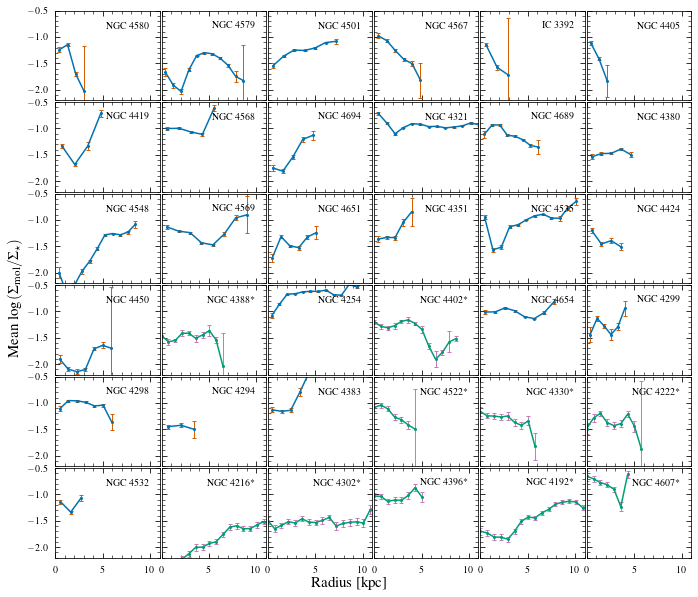

In [5]:
# MOSAIC OF GAS FRACTION DATA

plot_order = NGVS_DECR_MEDIAN_M_DENSITY_IDX
plot_order_str = "DecrMedianSigmaStar"  # "DecrMeanSigmaStar" or "DecrMedianSigmaStar"

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9.5, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), galaxies[plot_order], inclinations[plot_order]):
    is_high_i = i >= i_threshold
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    # ax.set_ylim(-2.2, 0.1)  # if including masked regions
    ax.set_ylim(-2.2, -0.5)  # if not including masked regions (i.e., used _noIncludeBad file)
    ax.set_xlim(0, 11)
    pu.set_aspect(ax, 0.86, logx=False, logy=False)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)

fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
plt.subplots_adjust(left=0.07, right=1.0, bottom=0.05, top=1.0, wspace=0.015, hspace=0.02)
fig.savefig(GAS_FRAC_PATH + f"gas_fraction_i_corr_NGVS-VERTICO_{plot_order_str}_noNorm{incl_bad_str}.pdf")
plt.show()

Make mosaic of gas fraction uncertainties


In [3]:
PLOT_INCLUDE_BAD = False  # determines pickle file to use
# 
if PLOT_INCLUDE_BAD:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
# 
# Load uncertainties
# 
gas_fraction_unc_infile = GAS_FRAC_PATH + f"gas_fraction_unc_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}.pkl"
with open(gas_fraction_unc_infile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
avg_function = radial_profiles[0].rp_options["func"]
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

i_threshold = 80  # degree

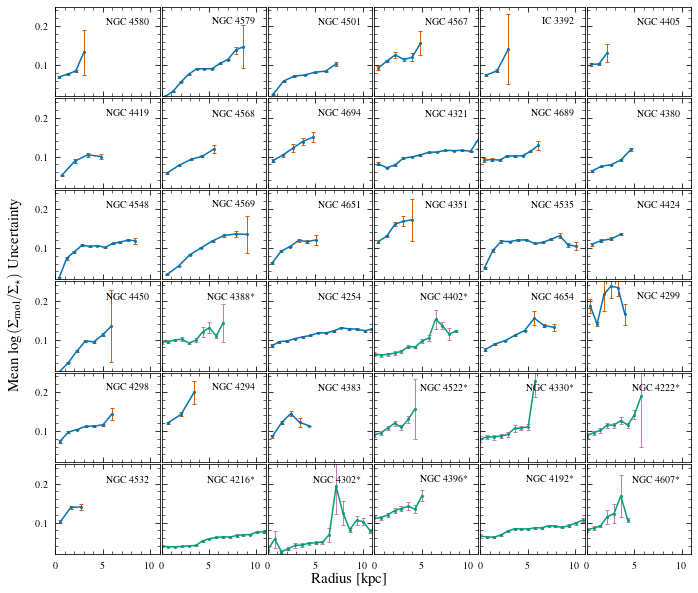

In [5]:
# MOSAIC OF GAS FRACTION UNCERTAINTIES

plot_order = NGVS_DECR_MEDIAN_M_DENSITY_IDX  # NGVS_DECR_MEAN_M_DENSITY_IDX or NGVS_DECR_MEDIAN_M_DENSITY_IDX
plot_order_str = "DecrMedianSigmaStar"  # "DecrMeanSigmaStar" or "DecrMedianSigmaStar"

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9.5, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), galaxies[NGVS_DECR_MEDIAN_M_DENSITY_IDX], inclinations[NGVS_DECR_MEDIAN_M_DENSITY_IDX]):
    is_high_i = i >= i_threshold
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(0.02, 0.25)
    ax.set_xlim(0, 11)
    pu.set_aspect(ax, 0.86, logx=False, logy=False)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)

fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$ Uncertainty",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
plt.subplots_adjust(left=0.07, right=1.0, bottom=0.05, top=1.0, wspace=0.015, hspace=0.02)
fig.savefig(GAS_FRAC_PATH + f"gas_fraction_unc_i_corr_NGVS-VERTICO_{plot_order_str}_noNorm{incl_bad_str}.pdf")
plt.show()